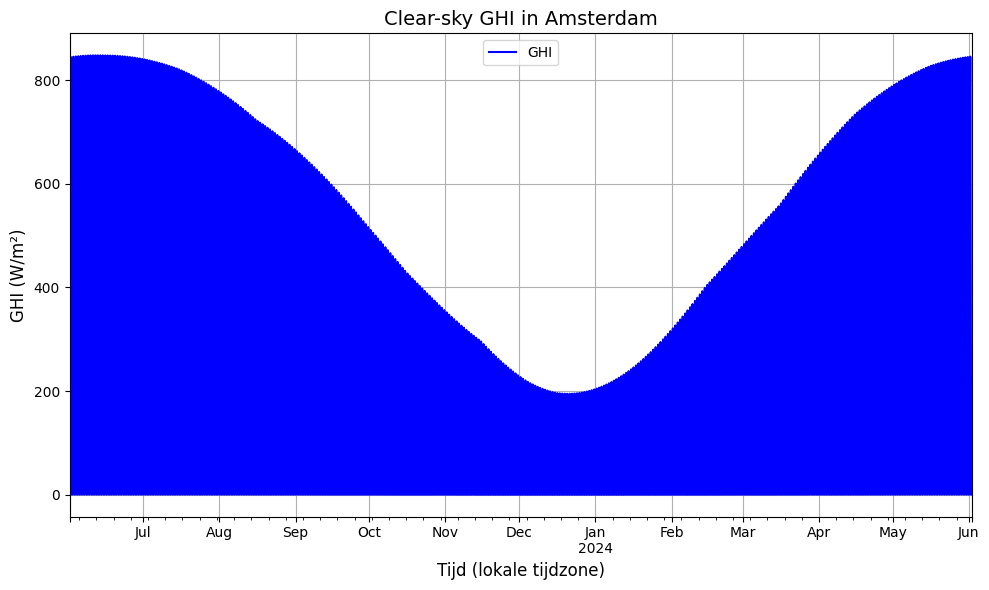

In [1]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Initialiseer locatie
location_amsterdam = Location(
    latitude=latitude_amsterdam, 
    longitude=longitude_amsterdam, 
    tz=timezone_amsterdam, 
    name=name_amsterdam
)

# Definieer de tijdstippen in UTC
times = pd.date_range(start='2023-06-01', end='2024-06-02', freq='1H', tz='UTC')

# Bereken de zonnepositie
solar_position_amsterdam = location_amsterdam.get_solarposition(times)

# Bereken de clear-sky straling met het Ineichen-model
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')

# Converteer tijd naar lokale tijdzone
clearsky_amsterdam.index = clearsky_amsterdam.index.tz_convert(timezone_amsterdam)

# Maak een enkele plot voor de GHI
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
clearsky_amsterdam['ghi'].plot(ax=ax, label='GHI', color='blue')

# Titel, labels en grid
ax.set_title(f'Clear-sky GHI in {name_amsterdam}', fontsize=14)
ax.set_xlabel('Tijd (lokale tijdzone)', fontsize=12)
ax.set_ylabel('GHI (W/m²)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

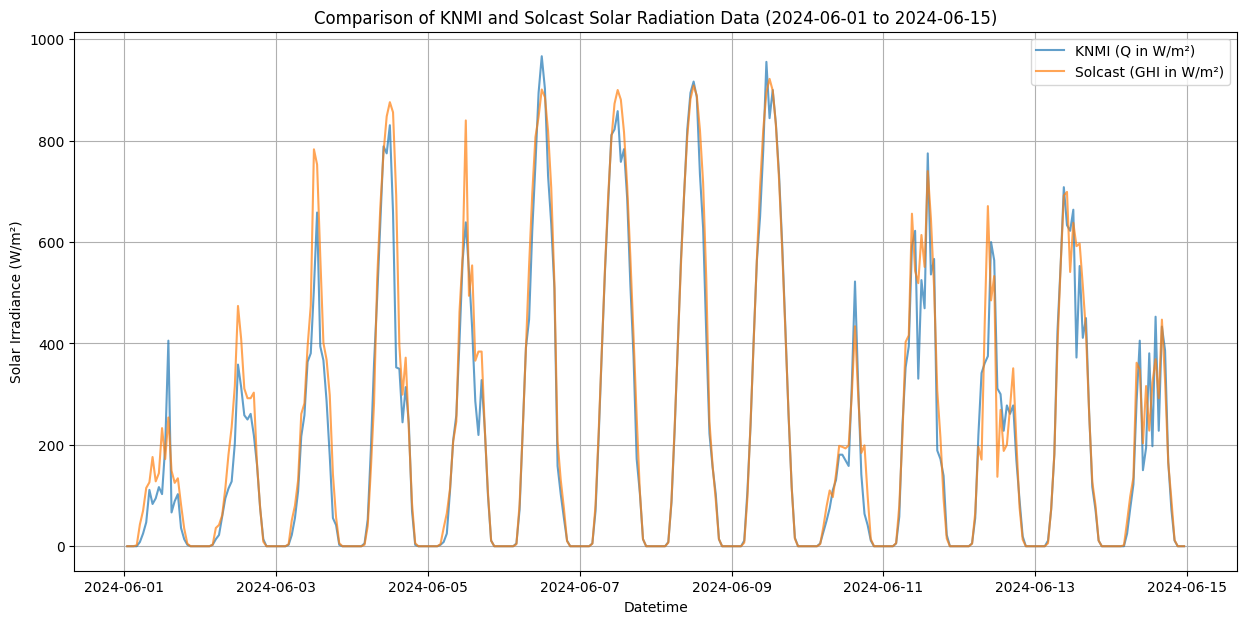

In [2]:
import Weer_data_inladen

# Load KNMI and Solcast data
knmi_data = Weer_data_inladen.load_knmi_data('data/KNMI_weerdata.txt')
solcast_data = Weer_data_inladen.load_solcast_data('data/Solcast_data_2.csv')

Weer_data_inladen.plot_comparison(knmi_data, solcast_data, '2024-06-01', '2024-06-15')

Totale jaarlijkse energieopbrengst voor Amsterdam: 408.79 kWh


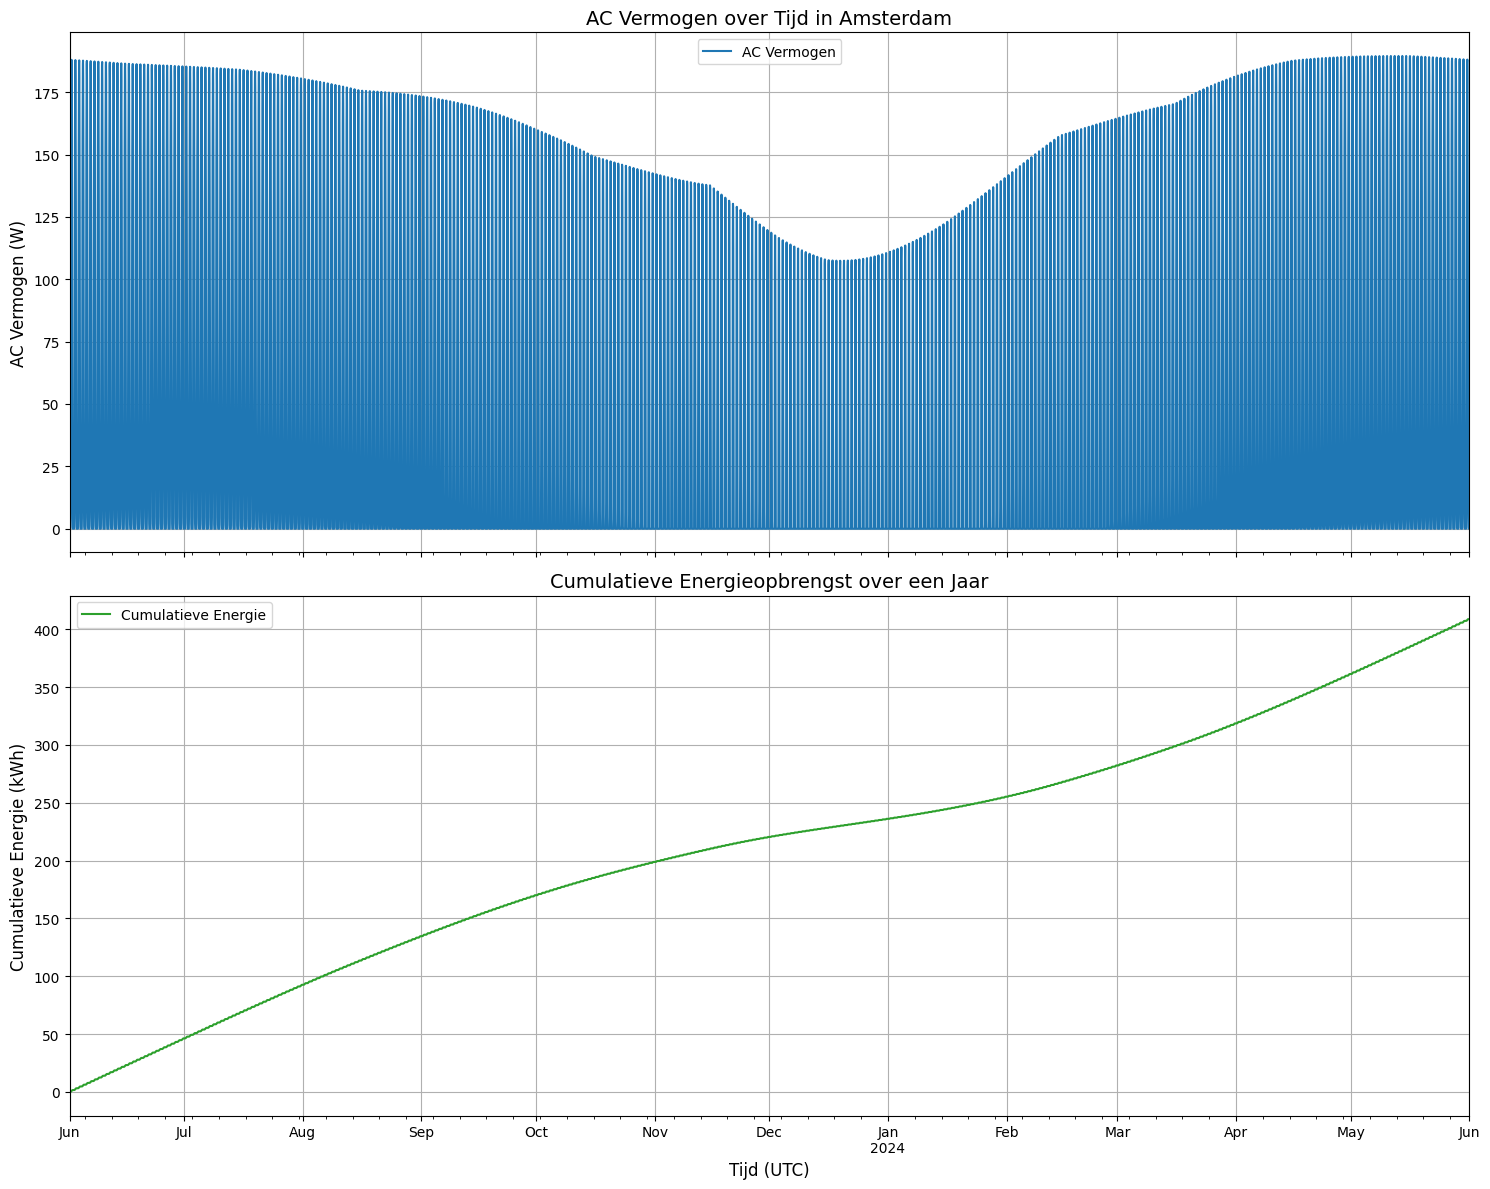

In [3]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Initialiseer locatie
location_amsterdam = Location(
    latitude=latitude_amsterdam, 
    longitude=longitude_amsterdam, 
    tz=timezone_amsterdam, 
    name=name_amsterdam
)

# Definieer de tijdstippen in UTC over een jaar
times = pd.date_range(start='2023-06-01', end='2024-06-01', freq='1H', tz='UTC')

# Bereken de zonnepositie en clear-sky straling
solar_position_amsterdam = location_amsterdam.get_solarposition(times)
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')

# Voeg temperatuur en windsnelheid toe aan de weergegevens
weather_amsterdam = clearsky_amsterdam.copy()
weather_amsterdam['temp_air'] = 15  # Luchttemperatuur in graden Celsius
weather_amsterdam['wind_speed'] = 2  # Windsnelheid in m/s

# Haal module- en omvormerparameters op
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# Definieer PV-systeem
system_amsterdam = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

# Maak ModelChain-object en voer berekeningen uit
mc_amsterdam = pvlib.modelchain.ModelChain(system_amsterdam, location_amsterdam)
mc_amsterdam.run_model(weather_amsterdam)

# Haal de AC-vermogenoutput op
ac_power_amsterdam = mc_amsterdam.results.ac

# Bereken de totale energieopbrengst in kWh
energy_amsterdam = ac_power_amsterdam.sum() / 1000  # van Wh naar kWh

# Print de resultaten
print(f"Totale jaarlijkse energieopbrengst voor {name_amsterdam}: {energy_amsterdam:.2f} kWh")

# Visualiseer de resultaten
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# AC Vermogen over tijd
ac_power_amsterdam.plot(ax=axes[0], label='AC Vermogen', color='tab:blue')
axes[0].set_ylabel('AC Vermogen (W)', fontsize=12)
axes[0].set_title(f'AC Vermogen over Tijd in {name_amsterdam}', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Cumulatieve energieopbrengst
cumulative_energy_amsterdam = ac_power_amsterdam.cumsum() / 1000  # in kWh
cumulative_energy_amsterdam.plot(ax=axes[1], label='Cumulatieve Energie', color='tab:green')
axes[1].set_ylabel('Cumulatieve Energie (kWh)', fontsize=12)
axes[1].set_xlabel('Tijd (UTC)', fontsize=12)
axes[1].set_title('Cumulatieve Energieopbrengst over een Jaar', fontsize=14)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [4]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

def simulate_pv_system(location_name, latitude, longitude, timezone, surface_tilt, surface_azimuth, temp_air, wind_speed, start_date, end_date):
    """
    Simuleer een PV-systeem en retourneer de resultaten.

    Parameters:
    - location_name: Naam van de locatie (str)
    - latitude: Breedtegraad (float)
    - longitude: Lengtegraad (float)
    - timezone: Tijdzone (str)
    - surface_tilt: Hellingshoek van de panelen (float, in graden)
    - surface_azimuth: Oriëntatie van de panelen (float, in graden)
    - temp_air: Luchttemperatuur (float, in °C)
    - wind_speed: Windsnelheid (float, in m/s)
    - start_date: Startdatum van de simulatie (str, 'YYYY-MM-DD')
    - end_date: Einddatum van de simulatie (str, 'YYYY-MM-DD')

    Returns:
    - results: DataFrame met de AC-vermogenoutput en cumulatieve energieopbrengst.
    - totale_energie: Totale energieopbrengst in kWh.
    """

    # Initialiseer locatie
    location = Location(latitude=latitude, longitude=longitude, tz=timezone, name=location_name)

    # Definieer de tijdstippen in UTC
    times = pd.date_range(start=start_date, end=end_date, freq='1H', tz='UTC')

    # Bereken de clear-sky straling
    clearsky = location.get_clearsky(times, model='ineichen')

    # Voeg temperatuur en windsnelheid toe aan de weergegevens
    weather = clearsky.copy()
    weather['temp_air'] = temp_air
    weather['wind_speed'] = wind_speed

    # Haal module- en omvormerparameters op
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

    # Definieer PV-systeem
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        module_parameters=module,
        inverter_parameters=inverter,
        module_type='glass_polymer',
        racking_model='open_rack'
    )

    # Maak ModelChain-object en voer berekeningen uit
    mc = pvlib.modelchain.ModelChain(system, location)
    mc.run_model(weather)

    # Haal de AC-vermogenoutput op
    ac_power = mc.results.ac

    # Bereken cumulatieve energieopbrengst
    cumulative_energy = ac_power.cumsum() / 1000  # in kWh
    totale_energie = ac_power.sum() / 1000  # in kWh

    # Combineer resultaten in een DataFrame
    results = pd.DataFrame({
        'ac_power': ac_power,
        'cumulative_energy': cumulative_energy
    })

    return results, totale_energie


Totale jaarlijkse energieopbrengst in Amsterdam: 408.79 kWh


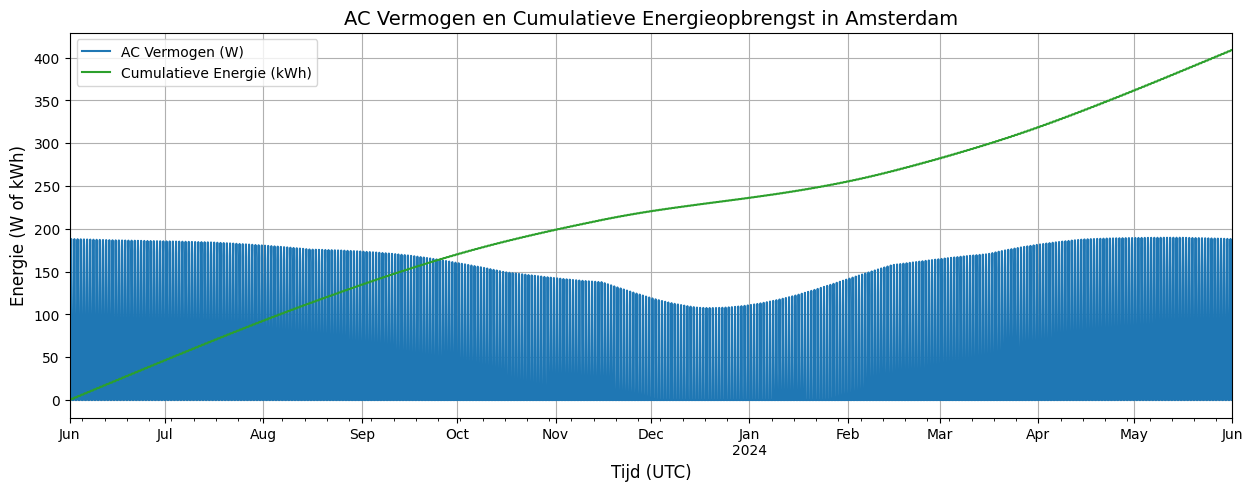

In [5]:
# Simulatie voor Amsterdam
results_amsterdam, energy_amsterdam = simulate_pv_system(
    location_name="Amsterdam",
    latitude=52.3676,
    longitude=4.9041,
    timezone="Europe/Amsterdam",
    surface_tilt=30,
    surface_azimuth=180,
    temp_air=15,
    wind_speed=2,
    start_date="2023-06-01",
    end_date="2024-06-01"
)

print(f"Totale jaarlijkse energieopbrengst in Amsterdam: {energy_amsterdam:.2f} kWh")

# Visualisatie van de resultaten
results_amsterdam['ac_power'].plot(figsize=(15, 5), label='AC Vermogen (W)', color='tab:blue')
results_amsterdam['cumulative_energy'].plot(figsize=(15, 5), label='Cumulatieve Energie (kWh)', color='tab:green')
plt.title('AC Vermogen en Cumulatieve Energieopbrengst in Amsterdam', fontsize=14)
plt.ylabel('Energie (W of kWh)', fontsize=12)
plt.xlabel('Tijd (UTC)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


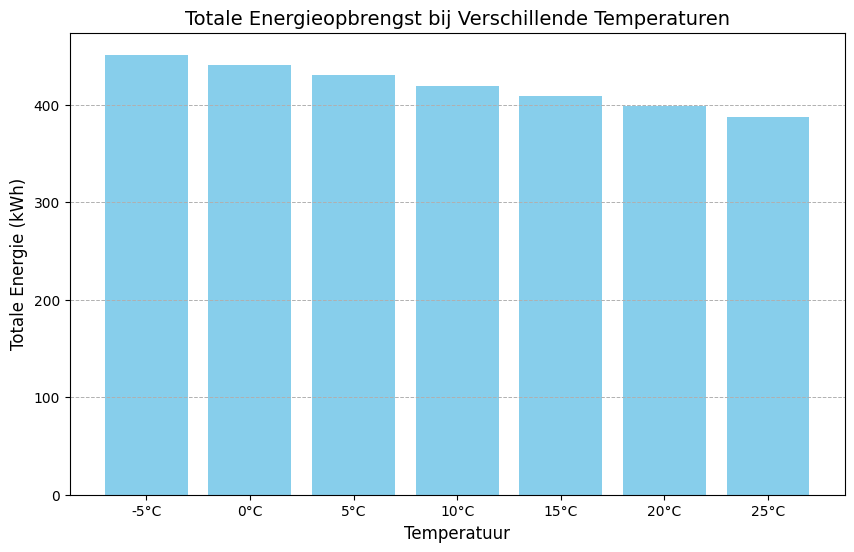

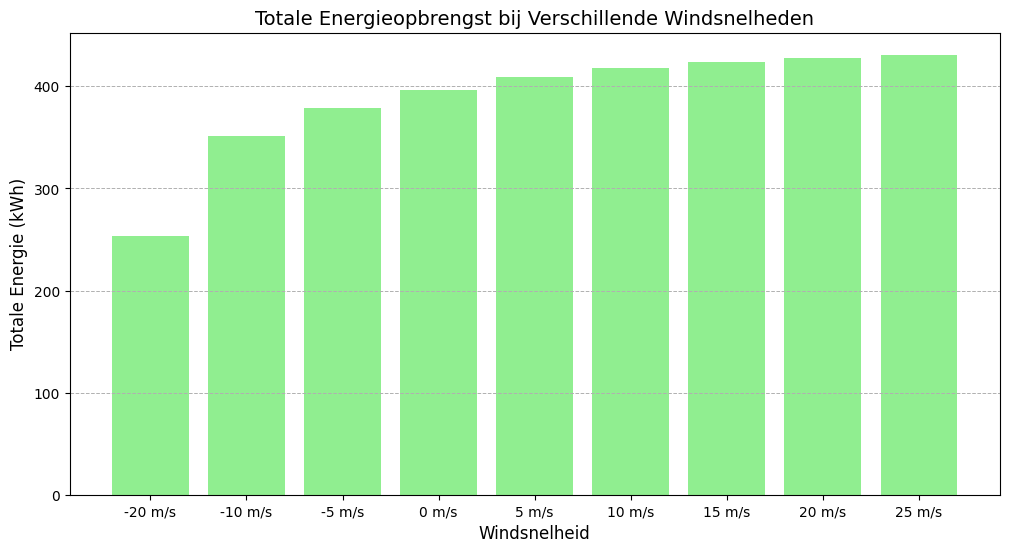

In [6]:
# Importeer benodigde bibliotheken
import matplotlib.pyplot as plt

# Temperatuurvariaties
temps = [-5, 0, 5, 10, 15, 20, 25]
temp_energies = []  # Opslag voor totale energieopbrengsten

# Simuleer energieopbrengst voor verschillende temperaturen
for temp in temps:
    _, energy = simulate_pv_system(
        location_name="Amsterdam",
        latitude=52.3676,
        longitude=4.9041,
        timezone="Europe/Amsterdam",
        surface_tilt=30,
        surface_azimuth=180,
        temp_air=temp,
        wind_speed=2,
        start_date="2023-06-01",
        end_date="2024-06-01"
    )
    temp_energies.append(energy)

# Visualisatie in een bar plot voor temperaturen
plt.figure(figsize=(10, 6))
plt.bar([str(temp) + "°C" for temp in temps], temp_energies, color='skyblue')
plt.title('Totale Energieopbrengst bij Verschillende Temperaturen', fontsize=14)
plt.ylabel('Totale Energie (kWh)', fontsize=12)
plt.xlabel('Temperatuur', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# Windsnelheidvariaties
windspeeds = [-20, -10, -5, 0, 5, 10, 15, 20, 25]
windspeed_energies = []  # Opslag voor totale energieopbrengsten

# Simuleer energieopbrengst voor verschillende windsnelheden
for windspeed in windspeeds:
    _, energy = simulate_pv_system(
        location_name="Amsterdam",
        latitude=52.3676,
        longitude=4.9041,
        timezone="Europe/Amsterdam",
        surface_tilt=30,
        surface_azimuth=180,
        temp_air=18,
        wind_speed=windspeed,
        start_date="2023-06-01",
        end_date="2024-06-01"
    )
    windspeed_energies.append(energy)

# Visualisatie in een bar plot voor windsnelheden
plt.figure(figsize=(12, 6))
plt.bar([str(windspeed) + " m/s" for windspeed in windspeeds], windspeed_energies, color='lightgreen')
plt.title('Totale Energieopbrengst bij Verschillende Windsnelheden', fontsize=14)
plt.ylabel('Totale Energie (kWh)', fontsize=12)
plt.xlabel('Windsnelheid', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()





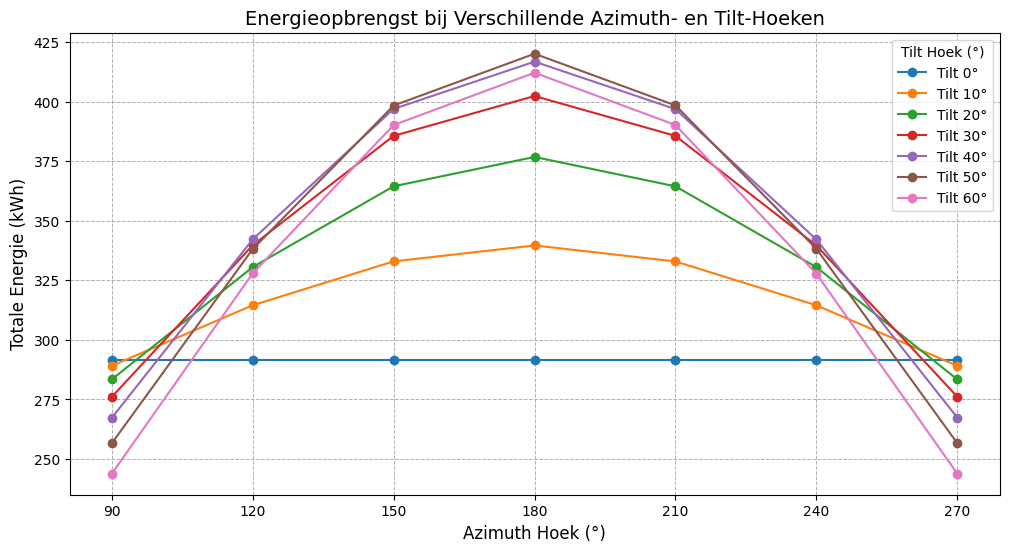

In [7]:
# Azimuth- en tilt-variaties
azimuths = [90, 120, 150, 180, 210, 240, 270]  # Azimuth in graden
tilts = [0, 10, 20, 30, 40, 50, 60]  # Tilt in graden

# Opslag voor resultaten
tilt_azimuth_results = {}

# Simuleer energieopbrengst voor verschillende tilt- en azimuth-hoeken
for tilt in tilts:
    energies = []
    for azimuth in azimuths:
        _, energy = simulate_pv_system(
            location_name="Amsterdam",
            latitude=52.3676,
            longitude=4.9041,
            timezone="Europe/Amsterdam",
            surface_tilt=tilt,
            surface_azimuth=azimuth,
            temp_air=18,
            wind_speed=2,
            start_date="2023-06-01",
            end_date="2024-06-01"
        )
        energies.append(energy)
    tilt_azimuth_results[tilt] = energies

# Plot de resultaten
plt.figure(figsize=(12, 6))

for tilt, energies in tilt_azimuth_results.items():
    plt.plot(azimuths, energies, label=f'Tilt {tilt}°', marker='o')

plt.title('Energieopbrengst bij Verschillende Azimuth- en Tilt-Hoeken', fontsize=14)
plt.ylabel('Totale Energie (kWh)', fontsize=12)
plt.xlabel('Azimuth Hoek (°)', fontsize=12)
plt.xticks(azimuths)  # Zorg dat de azimuths duidelijk op de x-as staan
plt.grid(True, linestyle='--', linewidth=0.7)
plt.legend(title="Tilt Hoek (°)")
plt.show()
